In [33]:
import numpy as np
import scipy.io
from midiutil import MIDIFile
from utils import *

In [34]:
key_time = 50e-3*0.5
Fs = 48000

## picked keys
#keys = scipy.io.loadmat('MATLAB_data/23Feb_jc_key_2octave.mat')['key']
keys = scipy.io.loadmat('MATLAB_data/23Feb_jc_key.mat')['key']

##freq of notes on piano
#notes_list = scipy.io.loadmat('notes_112.mat')['notes'] 
notes_list = scipy.io.loadmat('notes_100.mat')['notes'] 
# notes_list = scipy.io.loadmat('notes_88.mat')['notes']

##freq of t-f components
#freq_list = scipy.io.loadmat('freq_480_two_octave_down.mat')['f_cropped'] 
freq_list = scipy.io.loadmat('freq_480_octave_down.mat')['f_cropped'] 
# freq_list = scipy.io.loadmat('freq_480.mat')['f_cropped']
# freq_list = scipy.io.loadmat('freq_441.mat')['f_cropped']


notes_list = notes_list.reshape(np.size(notes_list))
freq_list = freq_list.reshape(np.size(freq_list))

note_num = 100 #88+12, 12 from upper octave

intensity_map = scipy.io.loadmat('MATLAB_data/23Feb_jc_int_1octave.mat')['filtered_int_db']
#intensity_map = scipy.io.loadmat('MATLAB_data/23Feb_jc_int_nm_1octave.mat')['filtered_int_nm']


In [35]:
def scale_int_old(intensity_map):
    #scale the intensity map(0-1) to maximum=scale
    scale = 36
    l = np.array(intensity_map)
    l = l * scale / np.amax(l)
    return l.tolist()
    

In [36]:
def intensity2sign(intensity):
    #quantize the intensity -> to dynamic sign
    int_nm = round(intensity/16)*16
    if int_nm <=16:
        return 'ppp'
    elif int_nm ==32:
        return 'pp'
    elif int_nm ==48:
        return 'p'
    elif int_nm ==64:
        return 'mp'
    elif int_nm ==80:
        return 'mf'
    elif int_nm ==96:
        return 'f'
    elif int_nm ==112:
        return 'ff'
    elif int_nm >=127:
        return 'fff'

In [37]:
def sign2vel(sign):
    #velocity ==> loudness
    #dynamic sign to velocity
    if sign == 'ppp':
        return 16
    elif sign == 'pp':
        return 32
    elif sign == 'p':
        return 48
    elif sign == 'mp':
        return 64
    elif sign == 'mf':
        return 80
    elif sign == 'f':
        return 96
    elif sign == 'ff':
        return 112
    elif sign == 'fff':
        return 127
    return False

In [38]:
def int2vel(intensity):
    #intensity(in dB) to loudness, lowest loudness is (0dB) 16  
    base = 16
    return 10**(intensity/40) * base

In [53]:
def picknotes(cur_key, cur_freq, cur_int, notes, notes_list):
    j = 0
    while j < len(cur_key):
        if cur_key[j] == 0:
            j += 1
            continue

        pitch = cur_key[j]
        while pitch > 88:
            pitch -= 12
        
        start = j
        ori_int = cur_int[j]
        while cur_key[j] != 0 and j < len(cur_key)-1:
            j += 1
            ori_int = max(ori_int,cur_int[j])
        end = j - 1
        # if end - start < 2: 
        #     end = start + 2 #all to 100ms
     
        intensity = get_intensity(cur_key[j-1],cur_freq,notes_list) * ori_int
        #intensity = ori_int
        intensity = int2vel(intensity)
        #intensity = get_intensity(cur_key[j-1],cur_freq,notes_list) * 100
        intensity_sign = intensity2sign(intensity)
        notes.append(Note(pitch, start, end, intensity))
        j += 1
    return notes

In [ ]:
intensity_map = scale_int(intensity_map)

In [61]:
notes = []
for i in range(np.shape(keys)[0]):
    cur_key = keys[i]
    cur_int = intensity_map[i]
    cur_freq = freq_list[i]
    notes = picknotes(cur_key, cur_freq, cur_int, notes, notes_list)

print(len(notes))

4098


In [41]:
def remove_repetitive(notes,note_num):
    #changed
    note_set = [0]*note_num
    i = 0
    while i < len(notes):
        note = notes[i]
        if note_set[note.pitch-1] == 0:
            note_set[note.pitch-1] = [note]
        else:
            delete = False
            for n in note_set[note.pitch-1]:
                if n.start == note.start and n.end == note.end:
                    n.intensity = max(n.intensity, note.intensity)
                    n.intensity_sign = intensity2sign(n.intensity)
                    del notes[i]
                    delete = True
                    i -= 1
                    break
            if not delete:
                note_set[note.pitch-1].append(note)
        i += 1
    return notes

In [64]:
notes = sorted(notes, key = lambda note: note.start)
new_notes = remove_repetitive(notes,note_num)

805
[pitch = 36(time = 35-35), intensity sign = ppp, intensity = 16.934, major = None, channel = -1,
 pitch = 37(time = 35-35), intensity sign = ppp, intensity = 17.379, major = None, channel = -1,
 pitch = 37(time = 35-36), intensity sign = ppp, intensity = 16.824, major = None, channel = -1,
 pitch = 37(time = 35-37), intensity sign = ppp, intensity = 16.829, major = None, channel = -1,
 pitch = 37(time = 35-38), intensity sign = ppp, intensity = 16.733, major = None, channel = -1,
 pitch = 38(time = 35-38), intensity sign = ppp, intensity = 21.802, major = None, channel = -1,
 pitch = 38(time = 35-41), intensity sign = ppp, intensity = 17.304, major = None, channel = -1,
 pitch = 39(time = 35-41), intensity sign = pp, intensity = 28.163, major = None, channel = -1,
 pitch = 40(time = 35-41), intensity sign = pp, intensity = 30.883, major = None, channel = -1,
 pitch = 41(time = 35-41), intensity sign = pp, intensity = 24.821, major = None, channel = -1,
 pitch = 50(time = 35-35), in

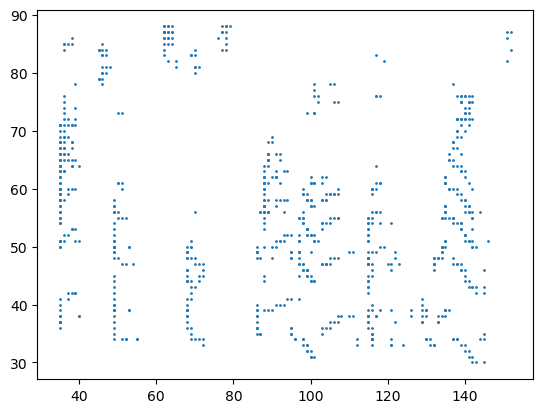

In [72]:
plot_notes(new_notes)
print(len(new_notes))
pprint(new_notes)

In [ ]:
nnew_notes = multichannel(new_notes,note_num)

In [ ]:
mf = MIDIFile(1)     # only 1 track
track = 0   # the only track
time = 0    # start at the beginning
mf.addTrackName(track, time, "Sample Track")
mf.addTempo(track, time, 1200)

In [ ]:
for note in nnew_notes:
    #v = int(20+note.sign()*20-40)
    #v = int(50+note.sign()*12.5)
    #v = int(note.intensity)
    v = int(sign2vel(note.intensity_sign))
    mf.addNote(track,note.channel,note.pitch+20, note.start, note.end-note.start+1,v)

In [ ]:
with open("midifile/23Feb_jc_inttest5.mid", 'wb') as outf:
   mf.writeFile(outf)

In [ ]:
# def picknotes_old(cur_key,cur_freq):
#     j = 0
#     while j < len(cur_key):
#         if cur_key[j] != 0:
            
#             d = {}
#             d['note'] = cur_key[j]
#             d['start'] = j
#             while cur_key[j] != 0 and j < len(cur_key)-1:
#                 j += 1
#             d['end'] = j - 1
#             intensity = get_intensity(cur_key[j-1],cur_freq,notes_list[cur_key[j-1]-1])
#             d['intensity'] = intensity
#             notes.append(d)
#         j += 1